# Исследование нефтедобывающей компании

Предоставлены данные добывающей компании «ГлавРосГосНефть» - пробы нефти в трёх регионах.   
Признаки - характеристики для скважин: качество нефти (три показателя) и объём её запасов (указан в тысячах баррелей).

Бизнес задача: решить, где бурить новую скважину.  
Метрика для модели машинного обучения: RMSE. 

Алгоритм выбора локации:  
1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов; 
2. Строят модель для предсказания объёма запасов в новых скважинах; 
3. Выбирают скважины с самыми высокими оценками значений (требуется выбрать 200 лучших точек для разработки); 
4. Определяют регион с максимальной суммарной прибылью отобранных скважин (и вероятностью убытков меньше 2.5%).

Для анализа предоставлен объем исторических данных. На которых следует продемонстрировать эффективность работы модели. 
Ограничения:
1. Следует учитывать, что в реальных условиях можно будет исследовать только по 500 скважин в каждом регионе.
2. Можно использовать только модель линейной регрессии.
3. Все признаки являются важными.

Параметры для расчета экономических показателей для обоснования эффективности работы модели:
1. Бюджет на разработку скважин в регионе — 10 млрд рублей.   
2. Один баррель сырья приносит 450 рублей дохода.   
3. Доход с каждой единицы продукта составляет 450 тыс. рублей.  

<a id='Назад к оглавлению'></a>

### План Исследования

#### Поделим наще исследование на несколько частей.

#### Часть 1. Анализ общей информации
<a href='#Анализ общей информации'> 1.1 Загрузка библиотек, чтение данных и анализ общей информации</a>

#### Часть 2. Разбиение данных на выборки
<a href='#2. Предподготовка данных, разбиение на выборки и построение модели машинного обучения'> 2.1 Предподготовка данных, разбиение на выборки и построение модели машинного обучения</a>

#### Часть. 3 Проведение бизнес-расчетов по выбору лучшего региона
<a href='#3.1 Подготовка к расчёту прибыли'> 3.1 Подготовка к расчёту прибыли</a>

<a href='#3.2 Реализация расчета основных экономических показателей по выбранным скважинам и предсказаниям модели'> 3.2 Реализация расчета основных экономических показателей по выбранным скважинам и предсказаниям модели</a>

<a href='#3.3 Расчёт рисков и прибыли для каждого региона'> 3.3 Расчёт рисков и прибыли для каждого региона</a>

#### Часть 4. Общий вывод
<a href='#4 Общий вывод'> 4.1 Общий вывод</a>

<a id='Анализ общей информации'></a>

### Часть 1. Анализ данных. 

#### 1.1 Загрузка библиотек, чтение данных и анализ общей информации

In [1]:
# # Для анализа данных будем использовать библиотеку pandas_profiling.
# # Установим библиотеку и изменим версию pandas c которой profiling работает стабильно
# !pip install pandas_profiling==1.4.1
# !pip install pandas==0.25.3

In [2]:
# Импортируем библиотеки, с помощью которых будем обрабатывать данные
import numpy as np
import pandas as pd
import pandas_profiling
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats as st

# для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from datetime import datetime # для формирования даты

# Установка настроек для отображения всех колонок при печати
pd.set_option('display.max_columns', None)

# для отключения FutureWarning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Прочитаем данные из 3 файлов и запишем каждый в отдельную переменную df_0, df_1, df_2
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# Запусим библиотеку pandas_profiling и посмотрим как выглядят статистики 
df_dict = {'df_0': df_0, 'df_1': df_1, 'df_2': df_2}
for key, value in df_dict.items():
    print('Анализ набора данных ' + key)
    pandas_profiling.ProfileReport(value)

Анализ набора данных df_0


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Анализ набора данных df_1


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


Анализ набора данных df_2


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Инструмент pandas_profiling позволяет изучить основную информацию о значениях и статистиках по признакам. Автоматический анализатор позволяет быстро получить информацию о типах данных, распределениях, наличиях пропусков и дублей в наборе данных. Так же можно увидеть информацию о корреляции между признаками или признаками и целевой переменной. Данный инструмент не позволяет ответить на все вопросы о наших данных, но помогает довольно быстро оценить основные проблемы, присутствующие в данных и определиться с инструментами для более детального анализа.

Корреляционная матрица и график scatterplot для набора данных: df_0


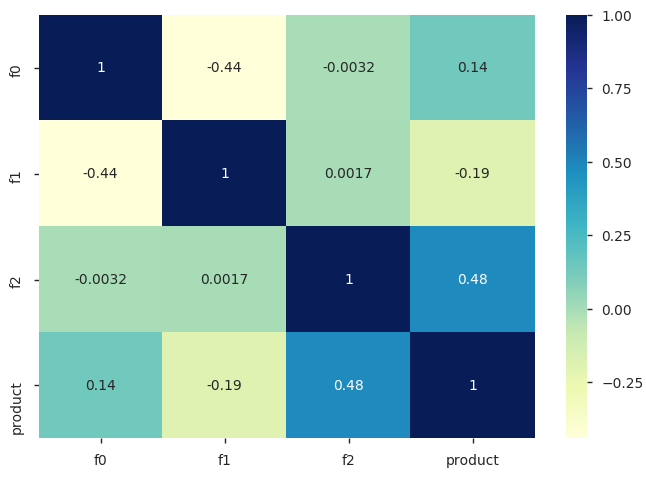

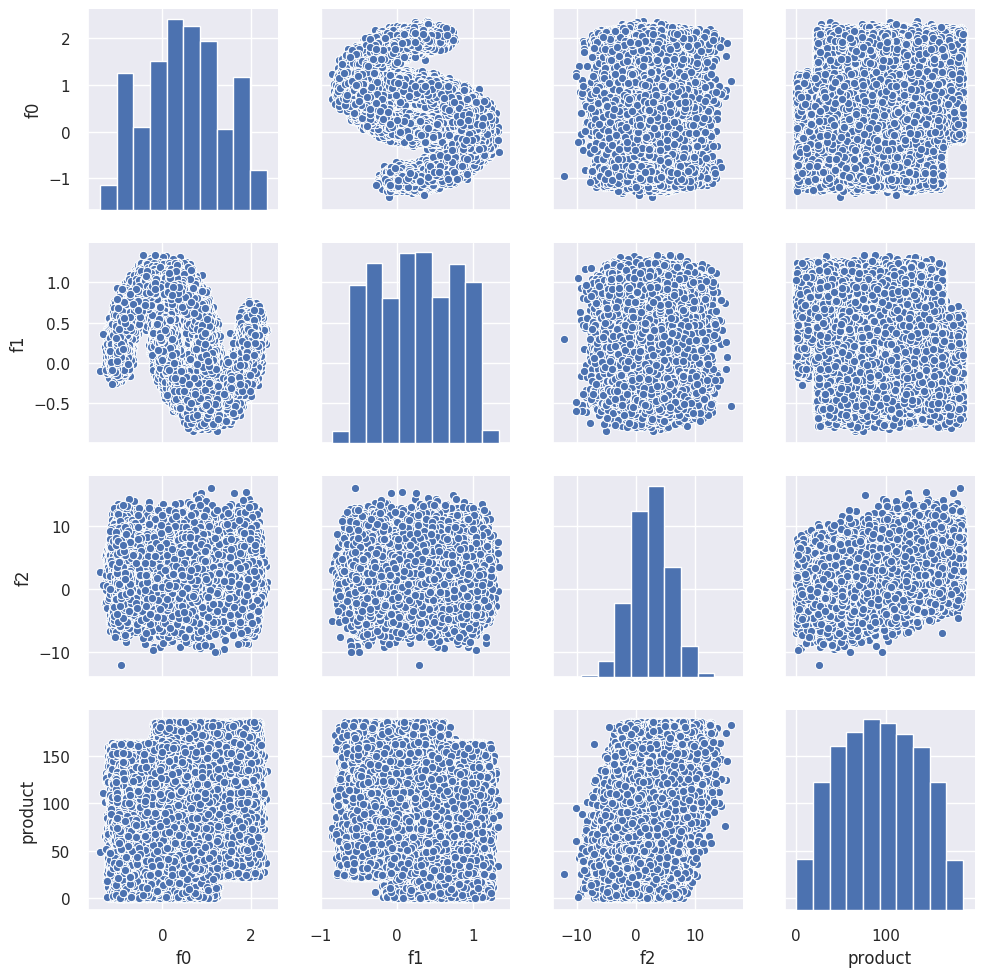

Корреляционная матрица и график scatterplot для набора данных: df_1


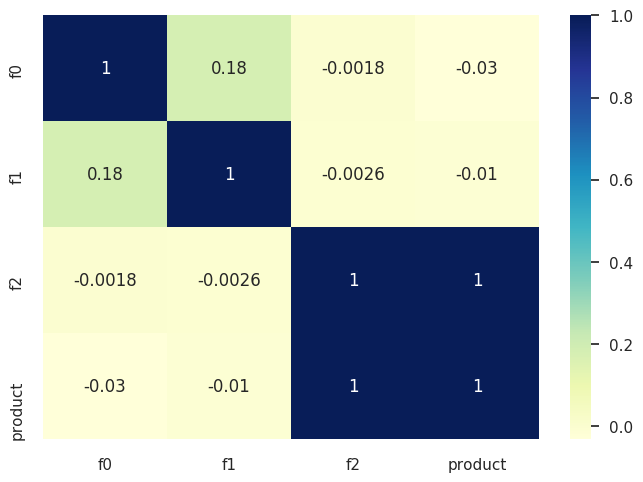

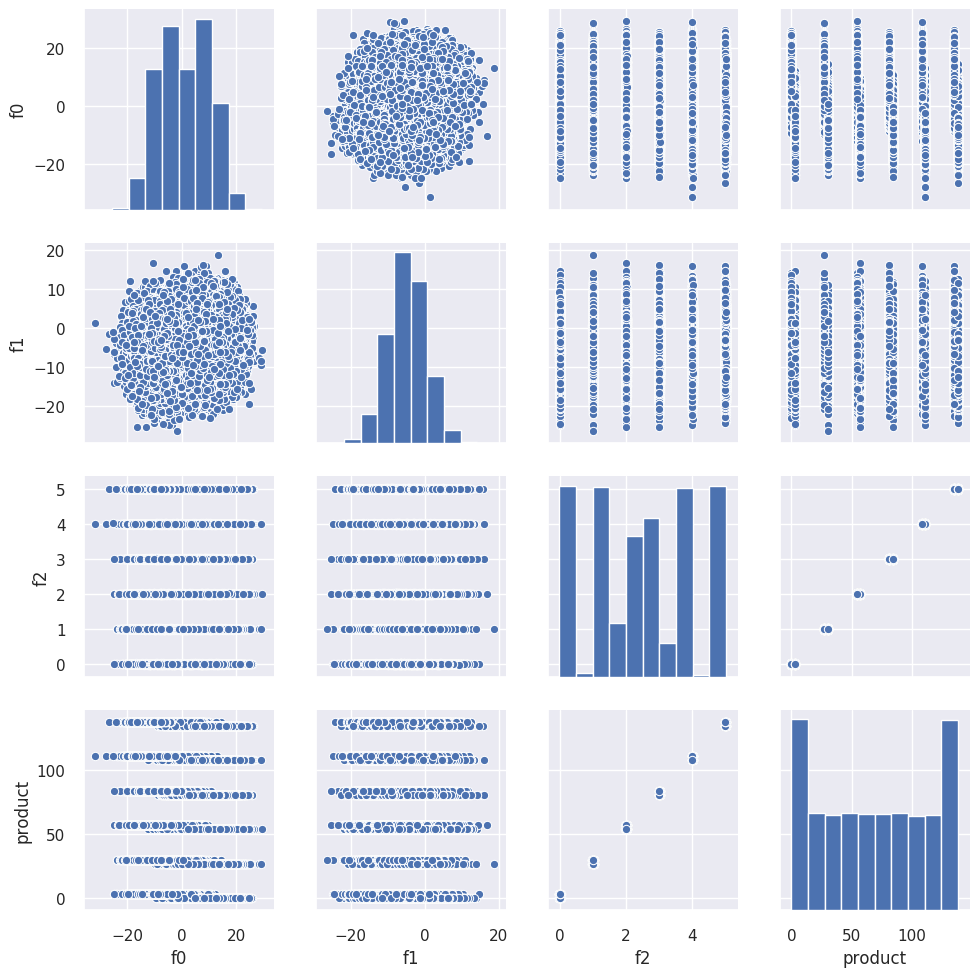

Корреляционная матрица и график scatterplot для набора данных: df_2


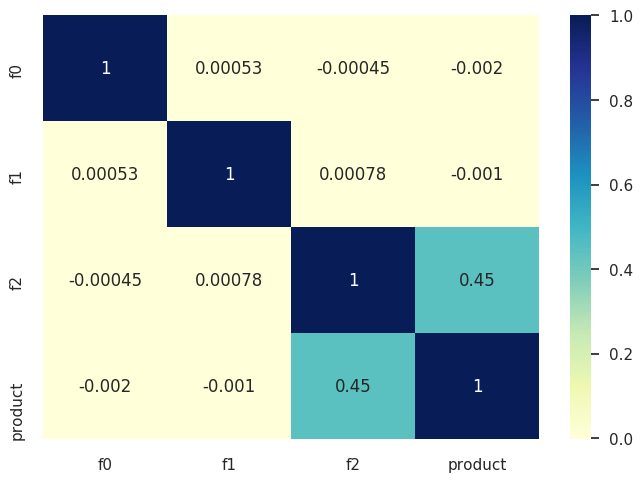

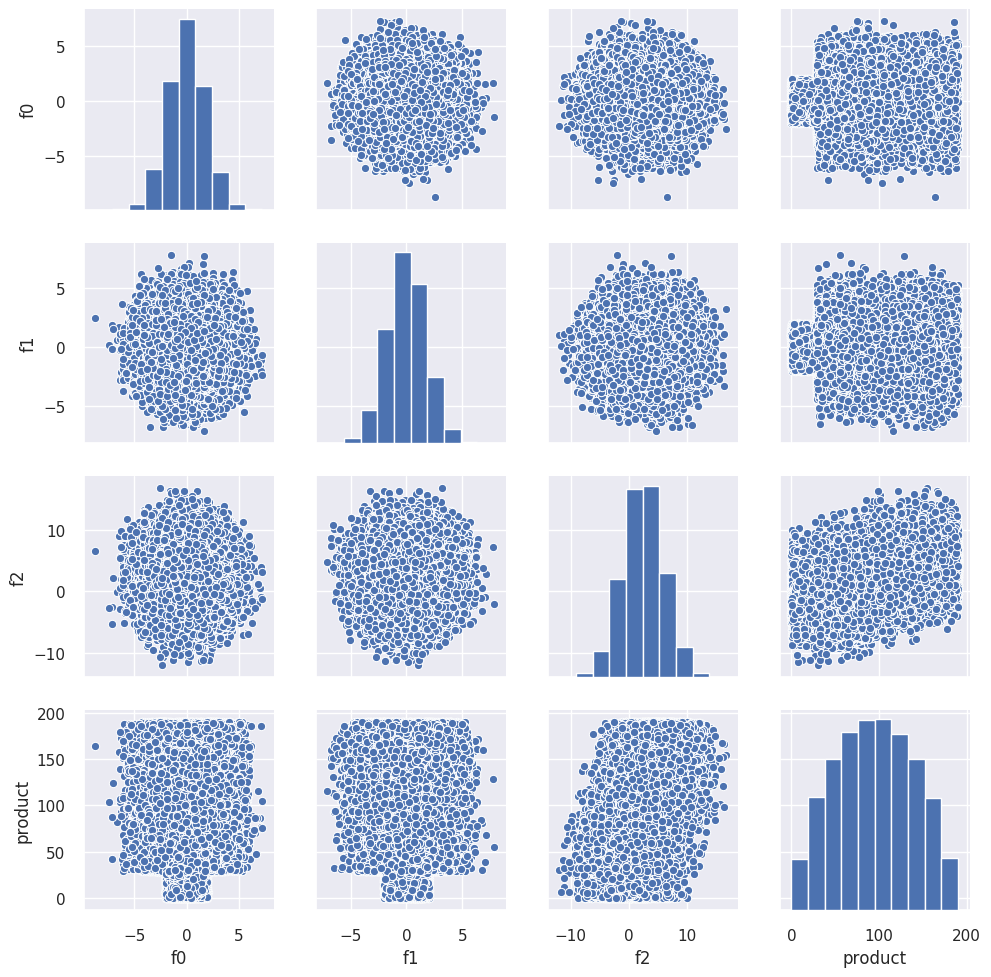

In [5]:
# Проверим корреляцию между признаками и построим график типа scatterplot
for key, value in df_dict.items():
    print('Корреляционная матрица и график scatterplot для набора данных: '+ key)
    a = sns.heatmap(value.corr(), annot = True, cmap="YlGnBu")
    b = sns.set()
    c = sns.pairplot(value, size = 2.5)
    plt.show();

In [6]:
# Используем в цикле метод info для определения типов данных признаков и описательных статистик по всем регионам
for key, value in df_dict.items():
    print('Анализ набора данных ' + key)
    value.info()
    value.describe()
    print('')

Анализ набора данных df_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Анализ набора данных df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Анализ набора данных df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
# В цикле посмотрим на все значения с дублями в идентификаторах скважин
for key, value in df_dict.items():
    list_to_drop = value[value['id'].duplicated()]['id'].tolist()
    print('Анализ набора данных ' + key)
    for id_ in list_to_drop:
        print(value.query('id == @id_'))
        print('----------------------')
    print('------------------------------------------------------')

Анализ набора данных df_0
         id        f0        f1         f2     product
931   HZww2  0.755284  0.368511   1.863211   30.681774
7530  HZww2  1.061194 -0.373969  10.430210  158.828695
----------------------
          id        f0        f1        f2    product
1364   bxg6G  0.411645  0.856830 -3.653440  73.604260
41724  bxg6G -0.823752  0.546319  3.630479  93.007798
----------------------
          id        f0        f1        f2    product
3389   A5aEY -0.039949  0.156872  0.209861  89.249364
51970  A5aEY -0.180335  0.935548 -2.094773  33.020205
----------------------
          id        f0        f1        f2    product
1949   QcMuo  0.506563 -0.323775 -2.215583  75.496502
63593  QcMuo  0.635635 -0.473422  0.862670  64.578675
----------------------
          id        f0        f1        f2     product
64022  74z30  0.741456  0.459229  5.153109  140.771492
66136  74z30  1.084962 -0.312358  6.990771  127.643327
----------------------
          id        f0        f1        f2 

In [8]:
# В цикле посмотрим на все значения с количеством нефти менее 1 барреля на скважину по всем регионам
for key, value in df_dict.items():
    print('Анализ набора данных ' + key)
    print("Количество скважин с запасом нефти менее 1 барреля: ", len(value.query('product < 1')))
    print('------------------------------------------------------')

Анализ набора данных df_0
Количество скважин с запасом нефти менее 1 барреля:  194
------------------------------------------------------
Анализ набора данных df_1
Количество скважин с запасом нефти менее 1 барреля:  8235
------------------------------------------------------
Анализ набора данных df_2
Количество скважин с запасом нефти менее 1 барреля:  191
------------------------------------------------------


#### Вывод

Посмотрим какая информация содержится в колонках датасетов:

- `id` — уникальный идентификатор скважины,  
- `f0`, `f1`, `f2` — три признака точек,  
- `product` — объём запасов в скважине (тыс. баррелей).    


Преобразование типов не требуется, пропуски отсутствуют.
Выявлено наличие дублей в колонке `id`, но при этом значения в других колонках различны. 
Можно предположить две причины:  
1. по одной и той же скважине было взято по две пробы. В таком случае нам неизвестно какое значение более корректно.  
2. появление второго значения по одной и той же скважине может свидетельствовать о том, что скважина уже была разработана и по ней взяли второй анализ. В ряде случаев это предположение подтвеждается данными - после второго анализа значение в колонке `product` ниже. Но в некоторых случаях это не так.
В связи с тем, что анализ не может выявить точной причины такого явления в данных, а значений статистически мало (менее 10% от объема данных), принято решение удалить дублируемые значения по скважинам. 

Признаки `f0`, `f1`, `f2` имеют различный разброс значений - требуется нормализация.

В наборе данный `df_1` высокий уровень корреляции между признаком `f2` и целевой переменной. Но, т.к. по условию задачи все признаки важны, удалять их нельзя.

Анализ количества продукта по регионам выявил, что скважины в регионе `df_1` в среднем беднее, чем в двух других регионах. Так же в регионе `df_1` выявлено большое количество скважин с околонулевым запасом нефти. 

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='2. Предподготовка данных, разбиение на выборки и построение модели машинного обучения'></a>

### Часть 2. Предподготовка данных, разбиение на выборки и построение модели машинного обучения

In [9]:
# Напишем функцию, которая принимает на вход набор данных(набор данных по региону)
# удаляет в этом наборе дубли по идентификаторам скважин
# разделяет набор на признаковое пространство и целевую переменную
# разделяет набор данных на обучающий и валидационный наборы
# проверяет размер получившихся поднаборов
# применяет к этим поднаборам стандартизацию
# функция возвращает словарь:
# ключ: название поднабора
# значение: сам поднабор
def prepare(df):
    
    # Выявим дубли идентификаторов скважин
    # Удалим строки из набора данных по индексам идентификаторов
    list_to_drop = df[df['id'].duplicated()]['id'].tolist()
    index_list = df.query('id in @list_to_drop').index
    df.drop(index_list, inplace=True)
    # В переменную features поместим датасет удалив колонку product
    # Отделим от датасета колонку product с целевой переменной и поместим её в переменную target
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']
    
    # Поделим данные на обучающий и валидационный наборы
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=42)
    
    # Посмотрим на размер получившихся наборов данных
    data_dict = {'features_train': features_train,
                 'target_train': target_train,
                 'features_valid': features_valid,
                 'target_valid': target_valid}
    
    for key, value in data_dict.items():
        print('Размер набора данных ' + key, value.shape)
            
    # Стандартизируем признаки методом StandardScaler
    col = features.columns
    scaler = StandardScaler()
    scaler.fit(features_train[col])
    features_train[col] = scaler.transform(features_train[col])
    features_valid[col] = scaler.transform(features_valid[col])
        
    return data_dict

In [10]:
# Напишем функцию которая на вход принимает словарь с поднаборами данных по одному региону
# осуществляет инициализацию, обучение и вызов предсказаний модели на поднаборах
# и возвращает результаты в виде датасета правильных ответов и предсказанных значений
def model(prepare_data_dict):
    # Инициализируем модель LinearRegression    
    model = LinearRegression()
    # Обучим модель на обучающем поднаборе    
    model.fit(prepare_data_dict['features_train'], prepare_data_dict['target_train'])
    # Получим предсказания модели на валидационном поднаборе   
    predictions_valid = model.predict(prepare_data_dict['features_valid'])
    # Сохраним ответы и предсказанные значения на валидационном поднаборе в отдельном датасете
    target_valid = prepare_data_dict['target_valid'].copy().reset_index(drop=True)
    taget_predict_valid = pd.concat([target_valid, pd.Series(predictions_valid)], axis=1)
    taget_predict_valid.columns = ['true_answers', 'predict_answers']
    # Посчитаем значение метрики RMSE на валидационном поднаборе
    rmse = mean_squared_error(prepare_data_dict['target_valid'], predictions_valid) ** 0.5
    print('---------------------')
    print('Cредний запас предсказанного запаса сырья: ', round(predictions_valid.mean(), 2))
    print('Значение метрики RMSE на валидационном наборе: ', round(rmse, 2))
    print('-----------------------------------------------')
    
    return taget_predict_valid

In [11]:
# Напишем цикл, который для каждого набора данных по региону осуществляет
# вызов функции prepare, которая делает предобработку данных и разбивает первоначальный набор на поднаборы
# вызов функции model, которая делает предсказания линейной модели для валидационного поднабора
# в результате цикла собирается новый словарь:
# ключ: название набора данных
# значение: датасет правильных ответов и предсказанных значений модели на валидационном поднаборе
results_dict = {}
for key, value in df_dict.items():
    print('Обработаем набор данных: ' + key)
    prepare_data_dict = prepare(value)
    taget_predict_valid = model(prepare_data_dict)
    results_dict[key] = taget_predict_valid

Обработаем набор данных: df_0
Размер набора данных features_train (74985, 3)
Размер набора данных target_train (74985,)
Размер набора данных features_valid (24995, 3)
Размер набора данных target_valid (24995,)
---------------------
Cредний запас предсказанного запаса сырья:  92.29
Значение метрики RMSE на валидационном наборе:  37.76
-----------------------------------------------
Обработаем набор данных: df_1
Размер набора данных features_train (74994, 3)
Размер набора данных target_train (74994,)
Размер набора данных features_valid (24998, 3)
Размер набора данных target_valid (24998,)
---------------------
Cредний запас предсказанного запаса сырья:  69.17
Значение метрики RMSE на валидационном наборе:  0.89
-----------------------------------------------
Обработаем набор данных: df_2
Размер набора данных features_train (74994, 3)
Размер набора данных target_train (74994,)
Размер набора данных features_valid (24998, 3)
Размер набора данных target_valid (24998,)
---------------------
C

#### Вывод

Удалены строки с дублями в колонке `id`.    
Данные разделены на обучающий и валидационный наборы.  
Произведена нормализация данных.  
Для каждого региона построена модель Линейной регрессии.
На наборе данных `df_1` закономерно сравнительно лучшее качество по метрике RMSE - предполагаю, что такой результат обусловлен наличием признака, который практически полностью идентичен целевой переменной. Качество метрики в двух остальных регионах практически одинаково.   
Следует отметить, что несмотря на хорошие значения метрики, средний запас предсказанного объема сырья по региону `df_1` имеет самое низкое значение.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='3.1 Подготовка к расчёту прибыли'></a>

### Часть. 3 Проведение бизнес-расчетов по выбору лучшего региона

#### 3.1 Подготовка к расчёту прибыли

In [12]:
# Создадим константы для ключевых значений для дальнейших расчётов
BUDGET = 10000000000
NUMBER_OF_POINTS = 500
TOP = 200
PRICE_ONE_BAR = 450

# Рассчитаем зависимые показатели Бюджет на одну скважину и Стоимость одной единицы продукта
budget_one_point = BUDGET / TOP
profit_one_product = PRICE_ONE_BAR * 1000

In [13]:
# Посчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки 

# Рассчитаем достаточный объём сырья для безубыточной разработки одной новой скважины
normal_product = round(BUDGET/profit_one_product/200, 2)
print('Объём сырья для безубыточной разработки одной новой скважины: ', normal_product)
print('')
# Сравним полученный объём сырья со средним запасом в каждом регионе
for key, value in df_dict.items():
    print('Обработаем набор данных: ' + key)
    print('Количество скважин в регионе с запасом нефти менее 111 тыс. баррелей: ', len(value.query('product<111')))
    if value['product'].mean() >= normal_product:
        print('В данном регионе достаточное количество продукта для разработки.') 
        print('Средний запас нефти в скважинах по региону: ', round(value.query('product!=0')['product'].mean(), 0))
    else:
        print('В данном регионе недостаточное количество продукта для разработки.')
        print('Средний запас нефти в скважинах по региону: ', round(value.query('product!=0')['product'].mean(), 0))
    print('-------------------------------------------------')

Объём сырья для безубыточной разработки одной новой скважины:  111.11

Обработаем набор данных: df_0
Количество скважин в регионе с запасом нефти менее 111 тыс. баррелей:  63311
В данном регионе недостаточное количество продукта для разработки.
Средний запас нефти в скважинах по региону:  93.0
-------------------------------------------------
Обработаем набор данных: df_1
Количество скважин в регионе с запасом нефти менее 111 тыс. баррелей:  83456
В данном регионе недостаточное количество продукта для разработки.
Средний запас нефти в скважинах по региону:  75.0
-------------------------------------------------
Обработаем набор данных: df_2
Количество скважин в регионе с запасом нефти менее 111 тыс. баррелей:  61719
В данном регионе недостаточное количество продукта для разработки.
Средний запас нефти в скважинах по региону:  95.0
-------------------------------------------------


In [14]:
# Напишем функцию revenue для расчёта прибыли
# фунция принимает на вход правильные ответы и предсказания модели на валидационном наборе,
# а так же количество значений для отбора
# сортирует предсказания в порядке убывания
# по индексам отсортираванных значений для отбора(count), отбирает правильные ответы
# для отобранных значенний считается прибыль для каждой скважины
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    stat = [selected.min(), selected.mean(), selected.max()]
    return stat, (profit_one_product * selected.sum()) - BUDGET

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='3.2 Реализация расчета основных экономических показателей по выбранным скважинам и предсказаниям модели'></a>

#### 3.2  Реализация расчета основных экономических показателей по выбранным скважинам и предсказаниям модели

In [15]:
# Напишем функцию calculation для расчета основных экономических показателей
# фунция принимает на вход набор данных с правильными ответами и предсказаниями модели на валидационном наборе
# с помощью техники Bootstrap на 1000 выборок, осуществляет отбор 500 значений для имитации реального отбора скважин для анализа
# отобранные значения передаются в функцию revenue для выбора 200 лучших скважин и расчёта прибыли
# расчитвывает среднюю выручку (по результатм использования техники Bootstrap), 
# 95%-ый доверительный интервал и вероятность убыточного риска
def calculation(taget_predict_valid):
    
    state = np.random.RandomState(12345)
    statistic = []
    values = []
    for i in range(1000):
        target_subsample = taget_predict_valid['true_answers'].sample(n=NUMBER_OF_POINTS, replace=True, random_state=state)
        probs_subsample = taget_predict_valid['predict_answers'][target_subsample.index]
        stat, val = revenue(target_subsample, probs_subsample, TOP)
        statistic.append(stat)
        values.append(val)
        
    values = pd.Series(values)
    statistic = pd.DataFrame(statistic, columns=['min', 'mean', 'max'])
    print('Минимальное количество запаса нефти в рассматриваемых к разработке скважинах: ', round(statistic['min'].min(),2)) 
    print('Среднее количество запаса нефти в рассматриваемых к разработке скважинах: ', round(statistic['mean'].mean(),2)) 
    print('Максимальное количество запаса нефти в рассматриваемых к разработке скважинах: ', round(statistic['max'].max(),2))
        
    mean = values.mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    risk_persent = (values<0).mean()

    print('Начало и конец 95%-го доверительного интервала:', round(lower,2), round(upper,2))
    print("Средняя прибыль:", round(mean, 2))
    print("Риск убыточности: {:.1%}".format(risk_persent))
    print("------------------------------")

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='3.3 Расчёт рисков и прибыли для каждого региона'></a>

#### 3.3  Расчёт рисков и прибыли для каждого региона

In [16]:
# Осуществим вызов функции calculation в цикле для раждого региона
for key, value in results_dict.items():
    print('Обработаем набор данных: ' + key)
    calculation(value)

Обработаем набор данных: df_0
Минимальное количество запаса нефти в рассматриваемых к разработке скважинах:  0.05
Среднее количество запаса нефти в рассматриваемых к разработке скважинах:  115.83
Максимальное количество запаса нефти в рассматриваемых к разработке скважинах:  185.36
Начало и конец 95%-го доверительного интервала: -129560497.68 999548628.95
Средняя прибыль: 424643758.93
Риск убыточности: 6.6%
------------------------------
Обработаем набор данных: df_1
Минимальное количество запаса нефти в рассматриваемых к разработке скважинах:  80.86
Среднее количество запаса нефти в рассматриваемых к разработке скважинах:  117.19
Максимальное количество запаса нефти в рассматриваемых к разработке скважинах:  137.95
Начало и конец 95%-го доверительного интервала: 112938697.17 966480572.55
Средняя прибыль: 547005457.59
Риск убыточности: 0.6%
------------------------------
Обработаем набор данных: df_2
Минимальное количество запаса нефти в рассматриваемых к разработке скважинах:  0.24
Ср

#### Вывод

Вычислены и зафиксированы показатели требуемые для расчета экономической эффективности работы модели. 
Реализован бизнес-алгоритм по выбору 200 наиболее рентабельных скважин. 
С помощью техники Bootstrap рассчитана средняя выручка, 95%-ый доверительный интервал и вероятность убыточного риска.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='4 Общий вывод'></a>

### Часть. 4 Общий вывод

Проанализированы предоставленные наборы исторических данных по регионам. Особый интерес вызвали следующие особенности в данных:
1. наличие дублей в колонке `id`, но при этом значения в других колонках различны. Что может говорить либо о повторном взятии проб, либо о повторной разработке скважин. Такие случаи требуется уточнять у технологов. 
2. наличие высокого уровеня корреляции между признаком `f2` и целевой переменной. Такие особенности еще называют "ликами" в данных.
3. Большое количество скважин с низким содержанием запасов сырья. 
4. Средние показатели объемов сырья по скважинам в разрезе регионов. 

Для каждого региона построена модель Линейной регрессии.
Для региона `df_1` модель показала наилучшее значение качетсва по метрике RMSE. Качество метрики в двух остальных регионах практически одинаково хуже в сравнении с регионом `df_1`. 

Реализован бизнес-алгоритм по выбору 200 наиболее рентабельных скважин, среди отобранных 500, по которым бизнес-заказчик может провести анализ. 
С помощью техники Bootstrap рассчитана средняя выручка, 95%-ый доверительный интервал и вероятность убыточного риска.  

Анализ показателей убыточности показал, что добыча в регионе `df_1` будет безубыточна со средней выручкой не ниже выделенного бюджета. Данный регион (набор данных `geo_data_1`) предлагается к выбору для разработки скважин. 

Разработанный алгоритм модели машинного обучение позволил продемонстрировать полезность данного инструмента. Позволив даже в регионе, в котором в среднем скважины не обладают минимальным достаточным объемом запасов, найти и отобрать только те, которые будут максимально прибыльны и обладают хорошим запасом нефти. Как продемонстрировано в выводимых статистиках, к разработке в регионе `df_1` были выбраны скважины с минимальным запасом не менее 80 тыс. баррелей на скважину, в то время как в двух других регионах минимальные значения были близки к нулю.

Помимо анализа предоставленного выше, следует не забывать про георасположение скважин друг относительно друга, учитывая особенность единых пластов полезных ископаемых: если две скважины будут распогалаться близко, то в большой долей вероятности они будут черпать ресурсы из одного источника, а это означает, что и запас каждой из скважин будет усреднен и зависеть от обема общего источника.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>